In [1]:
# this is the total number of images 
Train_no = 33402

In [2]:
#This is to read the image from file into python
from scipy import misc
import glob
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

X_train=[]
directory = "C:\\Users\\Mert Ketenci\\Desktop\\train\\train\\"
img_type=".png"
#33402
for i in range(1,Train_no):
    image_name=[i,img_type]
    values = ''.join(str(v) for v in image_name)
    folder=[directory,values] 
    folder=''.join(folder)
    image = misc.imread(folder)
    X_train.append(image)


C:\Anaconda3\envs\dlenv\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


In [3]:
#This is the function to get the blue box position
def get_box_data(index, hdf5_data):
    """
    get `left, top, width, height` of each picture
    :param index:
    :param hdf5_data:
    :return:
    """
    meta_data = dict()
    meta_data['height'] = []
    meta_data['label'] = []
    meta_data['left'] = []
    meta_data['top'] = []
    meta_data['width'] = []

    def print_attrs(name, obj):
        vals = []
        if obj.shape[0] == 1:
            vals.append(obj[0][0])
        else:
            for k in range(obj.shape[0]):
                vals.append(int(hdf5_data[obj[k][0]][0][0]))
        meta_data[name] = vals

    box = hdf5_data['/digitStruct/bbox'][index]
    hdf5_data[box[0]].visititems(print_attrs)
    return meta_data

def get_name(index, hdf5_data):
    name = hdf5_data['/digitStruct/name']
    return ''.join([chr(v[0]) for v in hdf5_data[name[index][0]].value])

In [4]:
# Run this cell will be able to provide you the cropped image in 54*54*3 format
import h5py
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

mat_data = h5py.File('C:\\Users\\Mert Ketenci\\Desktop\\train\\train\\digitStruct.mat')
size = mat_data['/digitStruct/name'].size

#print (box)
label_Final = []
Pic_crop_Final = []
for i in range(Train_no-1):
    Array = np.array(X_train[i])
    pic = get_name(i, mat_data)
    box = get_box_data(i, mat_data)
    label = box['label']
    label_Final.append(''.join(str(int(x%10)) for x in label))

    #Increase location by 30%
    
    H = int(round((max(box['top'])+max(box['height'])) *1.03))
    L = int(round (min(box['left']) *(0.97)))
    if L<0:
        L =0
    T = int(round (min(box['top'])*(0.97)))
    if T<0:
        T = 0
    W = int(round((max (box ['left'])+ max(box['width']))*1.03))
    Pic_crop = Array [T:H,L:W]

    #resize data and append
    res_Pic_crop = cv2.resize(Pic_crop, dsize=(54, 54), interpolation=cv2.INTER_CUBIC)
    Pic_crop_Final.append(res_Pic_crop)

    

KeyboardInterrupt: 

In [ ]:
#Reshape the data from 54,54,3 into 54*54*3, and convert both label and image into array
import numpy as np
c = []
for i in range(Train_no-1):
    a = np.reshape(Pic_crop_Final[i],54*54*3)
    c.append(a)
c = np.asarray(c)
d = np.asarray(label_Final)



In [ ]:
import six.moves.cPickle as pickle
import os
import sys
import gzip

#Please change this directory
data_dir = 'C:\\Users\\Mert Ketenci\\Desktop\\train\\train\\'
output_file = 'trainpkl.gz'
out_path = os.path.join(data_dir, output_file)

#create document format
out = {}
out['labels'] = d
out['images'] = c

#save data
p = gzip.open(out_path, 'wb')
pickle.dump(out, p)
p.close()



In [7]:
#Read data file
import six.moves.cPickle as pickle
import os
import sys
import gzip
data_dir = 'C:\\Users\\Mert Ketenci\\Desktop\\train\\train\\'
output_file = 'trainpkl.gz'
out_path = os.path.join(data_dir, output_file)
f_test = gzip.open(out_path, 'rb')
test_set = pickle.load(f_test)
f_test.close()
# print (test_set)

In [23]:
# print the output
print(test_set['images'].shape)

(33401, 8748)


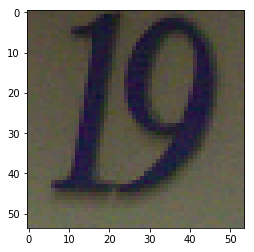

In [22]:
plt.imshow(test_set["images"][0].reshape(54,54,3))

In [24]:
#Create labels and length vector
label=[]
length=[]
for i in range(len(test_set["labels"])):
    label.append([int(x) for x in test_set["labels"][i]])
    length.append(len(label[-1]))

In [29]:
#To one hot encoding
thats_hot=np.zeros((Train_no-1,6,11), dtype=int)
for i in range(Train_no-1):
    for j in range(len(label[i])):
        thats_hot[i][j][label[i][j]]=1
        for j in range(len(label[i]),6):
            thats_hot[i][j][10]=1

In [30]:
#One hot encode length
hot_length = np.zeros((len(length), 7),dtype=int)
hot_length[np.arange(len(length),), length] = 1

In [31]:
Pic_crop_Final = test_set["images"].reshape(Train_no-1,54,54,3)

In [73]:
Pic_crop_Final1=Pic_crop_Final[:20000]
thats_hot1=thats_hot[:20000]
hot_length1=hot_length[:20000]

In [232]:
import tensorflow as tf
import random

tf.reset_default_graph()


x = tf.placeholder(tf.float32, shape=(None,54,54,3))
length_labels = tf.placeholder(tf.int64, shape=(None,None,))
digits_labels =  tf.placeholder(tf.int64, shape=(None,None,None))
drop_rate=0.5

with tf.variable_scope('hidden1'):
    conv = tf.layers.conv2d(x, filters=48, kernel_size=[5, 5], padding='same')
    norm = tf.layers.batch_normalization(conv)
    activation = tf.nn.relu(norm)
    pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=2, padding='same')
    hidden1 = pool  # 27 * 27 * 48
    # print(hidden1.shape)

with tf.variable_scope('hidden2'):
    conv = tf.layers.conv2d(hidden1, filters=64, kernel_size=[5, 5], padding='same')
    norm = tf.layers.batch_normalization(conv)
    activation = tf.nn.relu(norm)
    pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=1, padding='same')
    hidden2 = pool  # 27 * 27 * 64
    # print(hidden2.shape)

with tf.variable_scope('hidden3'):
    conv = tf.layers.conv2d(hidden2, filters=128, kernel_size=[5, 5], padding='same')
    norm = tf.layers.batch_normalization(conv)
    activation = tf.nn.relu(norm)
    pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=2, padding='same')
    hidden3 = pool  # 14 * 14 * 128
    # print(hidden3.shape)

with tf.variable_scope('hidden4'):
    conv = tf.layers.conv2d(hidden3, filters=160, kernel_size=[5, 5], padding='same')
    norm = tf.layers.batch_normalization(conv)
    activation = tf.nn.relu(norm)
    pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=1, padding='same')
    hidden4 = pool  # 14 * 14 *160
    # print(hidden4.shape)

with tf.variable_scope('hidden5'):
    conv = tf.layers.conv2d(hidden4, filters=192, kernel_size=[5, 5], padding='same')
    norm = tf.layers.batch_normalization(conv)
    activation = tf.nn.relu(norm)
    pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=2, padding='same')
    hidden5 = pool  # 7 * 7 * 192
    # print(hidden5.shape)

with tf.variable_scope('hidden6'):
    conv = tf.layers.conv2d(hidden5, filters=192, kernel_size=[5, 5], padding='same')
    norm = tf.layers.batch_normalization(conv)
    activation = tf.nn.relu(norm)
    pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=1, padding='same')
    hidden6 = pool  # 7 * 7 * 192
    # print(hidden6.shape)

with tf.variable_scope('hidden7'):
    conv = tf.layers.conv2d(hidden6, filters=192, kernel_size=[5, 5], padding='same')
    norm = tf.layers.batch_normalization(conv)
    activation = tf.nn.relu(norm)
    pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=2, padding='same')
    hidden7 = pool  # 4 * 4 * 192
    # print(hidden7.shape)

with tf.variable_scope('hidden8'):
    conv = tf.layers.conv2d(hidden7, filters=192, kernel_size=[5, 5], padding='same')
    norm = tf.layers.batch_normalization(conv)
    activation = tf.nn.relu(norm)
    pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=1, padding='same')
    hidden8 = pool  # 4 * 4 * 192

flatten = tf.reshape(hidden8, [-1, 4 * 4 * 192])

with tf.variable_scope('hidden9'):
    dense = tf.layers.dense(flatten, units=3072, activation=tf.nn.relu)
    dropout = tf.layers.dropout(dense, rate=drop_rate)
    hidden9 = dropout

with tf.variable_scope('hidden10'):
    dense = tf.layers.dense(hidden9, units=3072, activation=tf.nn.relu)
    dropout = tf.layers.dropout(dense, rate=drop_rate)
    hidden10 = dropout

with tf.variable_scope('digit_length'):
    dense = tf.layers.dense(hidden10, units=7)
    length = dense

with tf.variable_scope('digit1'):
    dense = tf.layers.dense(hidden10, units=11)
    digit1 = dense

with tf.variable_scope('digit2'):
    dense = tf.layers.dense(hidden10, units=11)
    digit2 = dense

with tf.variable_scope('digit3'):
    dense = tf.layers.dense(hidden10, units=11)
    digit3 = dense

with tf.variable_scope('digit4'):
    dense = tf.layers.dense(hidden10, units=11)
    digit4 = dense

with tf.variable_scope('digit5'):
    dense = tf.layers.dense(hidden10, units=11)
    digit5 = dense

length_logits, digits_logits = length, tf.stack([digit1, digit2, digit3, digit4, digit5], axis=1)

# length_labels = tf.one_hot(length_labels, 7)
# print(length_logits.shape, length_labels.shape)
length_cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits (labels=length_labels, logits=length_logits))
digit1_cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits (labels=digits_labels[:, 0], logits=digits_logits[:, 0, :]))
digit2_cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits (labels=digits_labels[:, 1], logits=digits_logits[:, 1, :]))
digit3_cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits (labels=digits_labels[:, 2], logits=digits_logits[:, 2, :]))
digit4_cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits (labels=digits_labels[:, 3], logits=digits_logits[:, 3, :]))
digit5_cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits (labels=digits_labels[:, 4], logits=digits_logits[:, 4, :]))
loss = length_cross_entropy + digit1_cross_entropy + digit2_cross_entropy + digit3_cross_entropy + digit4_cross_entropy + digit5_cross_entropy

train_step = tf.train.AdamOptimizer(1e-6).minimize(loss)
#d1 = tf.argmax(digit2, axis=1) it was before down init

p_l =tf.log(tf.nn.softmax(length,axis=1))
p_d1=tf.log(tf.nn.softmax(digit1,axis=1))
p_d2=tf.log(tf.nn.softmax(digit2,axis=1))
p_d3=tf.log(tf.nn.softmax(digit3,axis=1))
p_d4=tf.log(tf.nn.softmax(digit4,axis=1))
p_d5=tf.log(tf.nn.softmax(digit5,axis=1))

digit_probs = [p_d1,p_d2,p_d3,p_d4,p_d5]
ps0 = tf.add_n([p_l[:,0]])
ps1= tf.add_n([p_l[:,1],tf.reduce_max(p_d1,axis = 1)])
ps2= tf.add_n([p_l[:,2],tf.reduce_max(p_d1,axis = 1),tf.reduce_max(p_d2,axis = 1)])
ps3= tf.add_n([p_l[:,3],tf.reduce_max(p_d1,axis = 1),tf.reduce_max(p_d2,axis = 1),tf.reduce_max(p_d3,axis = 1)])
ps4= tf.add_n([p_l[:,4],tf.reduce_max(p_d1,axis = 1),tf.reduce_max(p_d2,axis = 1),tf.reduce_max(p_d3,axis = 1),tf.reduce_max(p_d4,axis = 1)])
ps5= tf.add_n([p_l[:,5],tf.reduce_max(p_d1,axis = 1),tf.reduce_max(p_d2,axis = 1),tf.reduce_max(p_d3,axis = 1),tf.reduce_max(p_d4,axis = 1),tf.reduce_max(p_d5,axis = 1)])
ps6= tf.add_n([p_l[:,6],tf.reduce_max(p_d1,axis = 1),tf.reduce_max(p_d2,axis = 1),tf.reduce_max(p_d3,axis = 1),tf.reduce_max(p_d4,axis = 1),tf.reduce_max(p_d5,axis = 1)])

ps = tf.stack([ps0,ps1, ps2, ps3, ps4, ps5,ps6], axis=1)
length =tf.argmax(ps,axis=1)
pred=[]
d1 = tf.argmax(digit1, axis=1)
d2 = tf.argmax(digit2, axis=1)
d3 = tf.argmax(digit3, axis=1)
d4 = tf.argmax(digit4, axis=1)
d5 = tf.argmax(digit5, axis=1)
digits = [d1,d2,d3,d4,d5]
#for l in range(length[0]):
 #   pred.append(digits[l])
    
    
num_train = 500
batch_size = 32
num_batch = num_train//batch_size
init = tf.initialize_all_variables()
with tf.Session() as sess:
    sess.run(init)
    for e in range(100):
        for i in range(num_batch):
            choice=np.random.choice(num_train, size=batch_size, replace=False)
            batch_x, batch_digits, batch_length = Pic_crop_Final1[choice], thats_hot1[choice], hot_length1[choice]
            sess.run(train_step, feed_dict={x:batch_x , length_labels:batch_length ,digits_labels:batch_digits})          
            length_tf,d1_tf,d2_tf,d3_tf,d4_tf,d5_tf = sess.run([length,d1,d2,d3,d4,d5], feed_dict={x:Pic_crop_Final[0:3].reshape(3,54,54,3)})
            digits = [d1_tf,d2_tf,d3_tf,d4_tf,d5_tf,d5_tf]
            sample_pred=[]
            
            for i in range(len(d1_tf)):
                digit_pred=[]
                for j in range(length_tf[i]):
                    digit_pred.append(digits[j][i])
                sample_pred.append(digit_pred)
            print("total loss",loss_tf)
            print("first digit",sample_pred)

IndexError: list index out of range

In [224]:
pred[0]=1

IndexError: list assignment index out of range

In [225]:
pred=[[[]]]*len(d1_tf)

In [76]:
total_prob=tf.zeros_like(p_l)
for i in range(1,5):
    for l in range(i+1):
        total_prob[:,i]=(p_l[:,i]+tf.reduce_max(digit_probs[:,i],axis =1))
pred_length = np.argmax(total_prob)

pred=[]
d1 = tf.argmax(digit1, axis=1)
d2 = tf.argmax(digit2, axis=1)
d3 = tf.argmax(digit3, axis=1)
d4 = tf.argmax(digit4, axis=1)
d5 = tf.argmax(digit5, axis=1)
digits = [d1,d2,d3,d4,d5]
for l in range(pred_length):
    pred.append(digits[l])

Tensor("digit_length/dense/BiasAdd:0", shape=(?, 7), dtype=float32)


[]

In [198]:
a.shape

(2, 54, 54, 3)

In [178]:
pred[1][0]

9

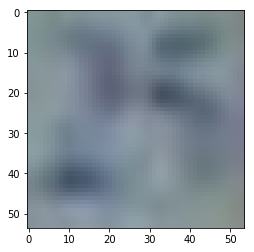

In [206]:
plt.imshow(Pic_crop_Final1[2])